In [67]:
from SPARQLWrapper import SPARQLWrapper, JSON



def runQuery(myQuery):
    endpoint = SPARQLWrapper("http://graphdb:7200/repositories/data")
    endpoint.setQuery(myQuery)
    endpoint.method = "POST"
    endpoint.setReturnFormat(JSON)
    return endpoint.query().convert()["results"]["bindings"]

def getRelationsForClass(classUri):
    myQuery = """
        SELECT DISTINCT ?p ?o
        FROM <http://www.ontotext.com/explicit>
        WHERE {
            ?instances rdf:type <%s>.
            ?instances ?p ?relatedClass.
            ?relatedClass rdf:type ?o.
        }
    """ % classUri
    return runQuery(myQuery)

def getRelationsForClass(classUri):
        myQuery = """
            SELECT DISTINCT ?p ?o
            FROM <http://www.ontotext.com/explicit>
            WHERE {
                ?instances rdf:type <%s>.
                ?instances ?p ?relatedClass.
                ?relatedClass rdf:type ?o.
            }
        """ % classUri
        return runQuery(myQuery)

In [69]:
classResults = runQuery("""
SELECT DISTINCT ?class
WHERE {
    ?instance rdf:type ?class.
}
""")

In [71]:
import rdflib

metaGraph = rdflib.Graph()
for classResult in classResults:
    #if it is a bnode, then skip
    if classResult["class"]["type"] == "bnode":
        continue
    
    myClass = classResult["class"]["value"]
    
    if not (myClass.startswith("http://www.w3.org/1999/02/22-rdf-syntax-ns#") | 
                    myClass.startswith("http://www.w3.org/2002/07/owl#") | 
                    myClass.startswith("http://www.w3.org/2000/01/rdf-schema#")):
        metaGraph.add((rdflib.term.URIRef(myClass), rdflib.term.URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"), rdflib.term.URIRef("http://www.w3.org/2002/07/owl#Class")))

        relations = getRelationsForClass(myClass)
        for relation in relations:
            predicateUri = rdflib.term.URIRef(relation["p"]["value"])
            domainUri = rdflib.term.URIRef(myClass)
            rangeUri = rdflib.term.URIRef(relation["o"]["value"])

            metaGraph.add([predicateUri, rdflib.term.URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"), rdflib.term.URIRef("http://www.w3.org/2002/07/owl#ObjectProperty")])
            metaGraph.add([predicateUri, rdflib.term.URIRef("http://www.w3.org/2000/01/rdf-schema#domain"), domainUri])
            metaGraph.add([predicateUri, rdflib.term.URIRef("http://www.w3.org/2000/01/rdf-schema#range"), rangeUri])
rdfXmlString = metaGraph.serialize(format="pretty-xml")
with open("output.rdf", 'w') as f:
    f.write(rdfXmlString)

In [123]:
from graphviz import Digraph
class StructureViz:
    def __init__(self, termEndpoint=None):
        self.excludedLiteralPredicates = [ ]
        self.namespaces = {
            "http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#": "ncit:",
            "http://www.cancerdata.org/roo/": "roo:",
            "http://mapping.local/": "map_",
            "http://purl.obolibrary.org/obo/UO_": "UO:",
            "http://www.w3.org/2001/XMLSchema#": "xsd:",
            "http://www.w3.org/2000/01/rdf-schema#": "rdfs:",
            "http://purl.bioontology.org/ontology/ICD10/": "icd:"
        }
        self.endpoint = termEndpoint
    
    def replaceToNamespace(self, uriObj):
        classString = str(uriObj)
        for key in self.namespaces.keys():
            classString = classString.replace(key, self.namespaces[key])
        return classString
    
    def runTermQuery(self, myQuery):
        endpoint = SPARQLWrapper(self.endpoint)
        endpoint.setQuery(myQuery)
        endpoint.method = "POST"
        endpoint.setReturnFormat(JSON)
        results = endpoint.query().convert()["results"]["bindings"]

        return results
    
    def getRelationsForClass(self, classUri):
        myQuery = """
            SELECT DISTINCT ?p ?o
            FROM <http://www.ontotext.com/explicit>
            WHERE {
                ?instances rdf:type <%s>.
                ?instances ?p ?relatedClass.
                ?relatedClass rdf:type ?o.
            }
        """ % classUri
        return runQuery(myQuery)
    
    def getSuperClassRelationForClass(self, classUri):
        myQuery = """
            SELECT DISTINCT ?p ?o
            FROM <http://www.ontotext.com/explicit>
            WHERE {
                <%s> ?p ?o.

                FILTER (?p IN (rdfs:subClassOf, owl:equivalentClass)).
                FILTER (?o NOT IN (<%s>))
            }
        """ % (classUri, classUri)
        return self.runTermQuery(myQuery)
    
    def getLabelForUri(self, uri, includeNewline=True):
        myQuery = """prefix rr: <http://www.w3.org/ns/r2rml#>
            prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>

            SELECT ?uriLabel
            WHERE {
                <%s> rdfs:label ?uriLabel.
            }""" % str(uri)
        
        results = self.runTermQuery(myQuery)
        
        for result in results:
            retVal = str(result["uriLabel"]["value"])
            if includeNewline:
                retVal + "\n"
            return retVal
        return ""
    
    def addRelations(self, relations, myClassShort, myClass, colorScheme=None):
        for relation in relations:
            predicate = relation["p"]["value"]
            predicateLabel = self.getLabelForUri(predicate)
            predicateUri = self.replaceToNamespace(predicate)
            objClassShort = self.replaceToNamespace(relation["o"]["value"])

            self.graph.edge(myClassShort.replace(":", "_"), objClassShort.replace(":", "_"), predicateLabel+"\n["+predicateUri+"]")
            
            if colorScheme is not None:
                myClassShort = self.replaceToNamespace(myClass)
                self.graph.node(myClassShort.replace(":", "_"), self.getLabelForUri(myClass)+"\n["+myClassShort+"]", colorScheme)
    
    def plotFromGraph(self, metaGraph):
        # create new graphviz canvas
        self.graph = Digraph(comment='R2RML Structure', format="png")
        self.graph.node_attr.update(color='lightblue2', style='filled')
        
        classes = metaGraph.query("SELECT * WHERE {?class rdf:type <http://www.w3.org/2002/07/owl#Class>}")
        for myClass in classes:
            myClass = str(myClass[0])
            myClassShort = self.replaceToNamespace(myClass)
            self.graph.node(myClassShort.replace(":", "_"), self.getLabelForUri(myClass)+"\n["+myClassShort+"]")
            
            relations = metaGraph.query("""SELECT ?p ?o WHERE { ?p <http://www.w3.org/2000/01/rdf-schema#domain> <%s>. ?p <http://www.w3.org/2000/01/rdf-schema#range> ?o.}""" % myClass)
            for relation in relations:
                predicate = str(relation["p"])
                predicateLabel = self.getLabelForUri(predicate)
                predicateUri = self.replaceToNamespace(predicate)
                objClassShort = self.replaceToNamespace(str(relation["o"]))
                self.graph.edge(myClassShort.replace(":", "_"), objClassShort.replace(":", "_"), predicateLabel+"\n["+predicateUri+"]")
            
            if len(relations)==0:
                if len(metaGraph.query("""SELECT ?p WHERE { ?p <http://www.w3.org/2000/01/rdf-schema#range> <%s>. }""" % myClass))==0:
                    relations = self.getSuperClassRelationForClass(myClass)
                    self.addRelations(relations, myClassShort, myClass, {"color": "lightgray", "style":"filled"})
        return self.graph

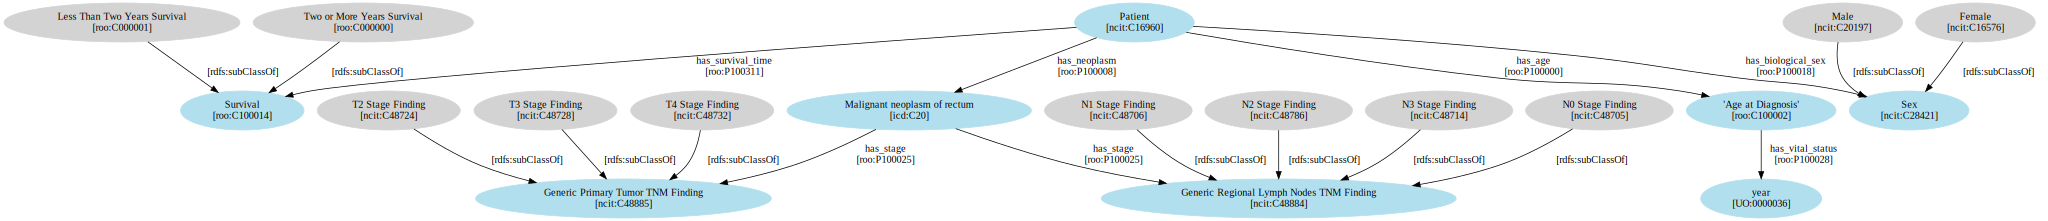

In [124]:
sv = StructureViz(termEndpoint="http://graphdb:7200/repositories/ontologies")
sv.plotFromGraph(metaGraph)